# Co-kriging

In [1]:
# import libraries

import numpy as np
import pandas as pd
import lasio
import math

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# read data

WELL_NAME = 'new_excel'
df = pd.read_excel('data/'+WELL_NAME+'.xlsx')
df = df.drop(columns=['FACIES'])
df

,X,Y,PORO,PERM,AI
0,100,900,0.100187,1.363890,5110.699751
1,100,800,0.107947,12.576845,4671.458560
2,100,700,0.085357,5.984520,6127.548006
3,100,600,0.108460,2.446678,5201.637996
4,100,500,0.102468,1.952264,3835.270322
...,...,...,...,...,...
256,780,669,0.175642,629.138468,3140.692477
257,50,779,0.091725,0.656564,6197.834381
258,430,589,0.139057,13.124324,3981.017070
259,130,489,0.099351,8.681915,4954.088777


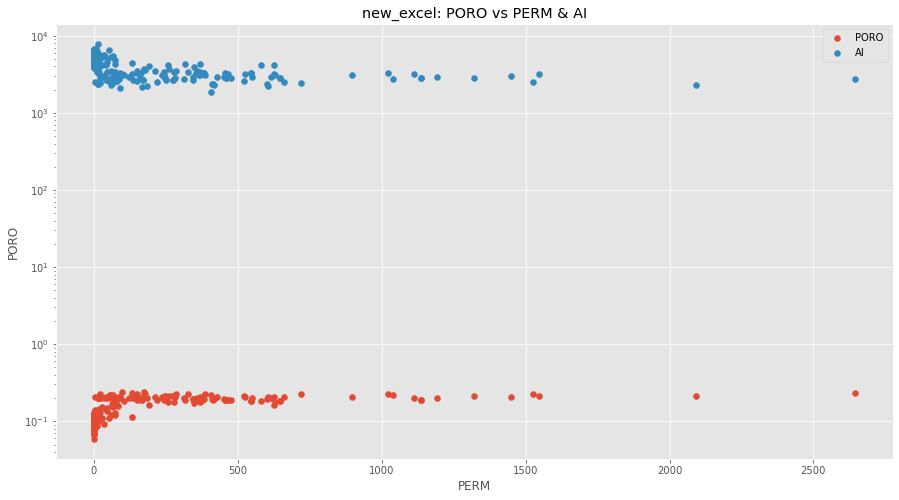

In [3]:
# check correlation between PORO, PERM and AI

plt.figure(figsize=(15,8))

plt.scatter(df.PERM, df.PORO, label='PORO')
plt.scatter(df.PERM, df.AI, label='AI')

plt.title(WELL_NAME + ': PORO vs PERM & AI')
plt.xlabel('PERM')
plt.ylabel('PORO')
plt.yscale('log')
plt.legend()
plt.show()

In [4]:
# calculate mean and std for each attribute

df_stat = pd.DataFrame()

for col in df.columns:
    mean = np.mean(df[col])
    std = np.std(df[col])
    df_stat[col] = np.array([mean, std])

df_stat.index = ['mean', 'std']    
df_stat

,X,Y,PORO,PERM,AI
mean,629.823755,488.344828,0.150357,183.711554,4203.657220
std,340.546135,166.349756,0.049687,344.297973,1315.226292


In [5]:
# normalize PORO, PERM and AI

df_standart = pd.DataFrame()

for col in df.columns:
    if col == 'Y' or col == 'X':
        pass
    else:
        df_standart[col] = 1 / df_stat.loc['std', col] * (df[col] - df_stat.loc['mean', col])
    
df_standart

,PORO,PERM,AI
0,-1.009719,-0.529622,0.689648
1,-0.853547,-0.497054,0.355681
2,-1.308188,-0.516201,1.462783
3,-0.843215,-0.526477,0.758790
4,-0.963802,-0.527913,-0.280094
...,...,...,...
256,0.508886,1.293725,-0.808199
257,-1.180024,-0.531676,1.516224
258,-0.227423,-0.495464,-0.169279
259,-1.026535,-0.508367,0.570572


In [6]:
# check normalization

df_stat = pd.DataFrame()

for col in df_standart.columns:
    mean = np.mean(df_standart[col])
    std = np.std(df_standart[col])
    df_stat[col] = np.array([mean, std])

df_stat.index = ['mean', 'std']    
df_stat

,PORO,PERM,AI
mean,-1.167648e-16,3.317908e-17,-5.686703e-17
std,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
# add coords to new normalized df

df_standart['X'] = df.X
df_standart['Y'] = df.Y
df_standart

,PORO,PERM,AI,X,Y
0,-1.009719,-0.529622,0.689648,100,900
1,-0.853547,-0.497054,0.355681,100,800
2,-1.308188,-0.516201,1.462783,100,700
3,-0.843215,-0.526477,0.758790,100,600
4,-0.963802,-0.527913,-0.280094,100,500
...,...,...,...,...,...
256,0.508886,1.293725,-0.808199,780,669
257,-1.180024,-0.531676,1.516224,50,779
258,-0.227423,-0.495464,-0.169279,430,589
259,-1.026535,-0.508367,0.570572,130,489


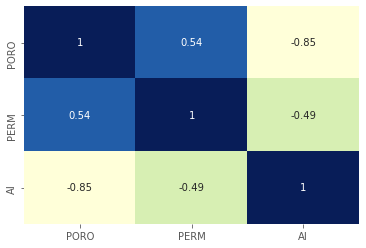

In [8]:
# correlation matrix making

cor_matrix = df[['PORO', 'PERM', 'AI']].corr()

sns.heatmap(cor_matrix, annot=True, cmap="YlGnBu", cbar=False)
plt.show()

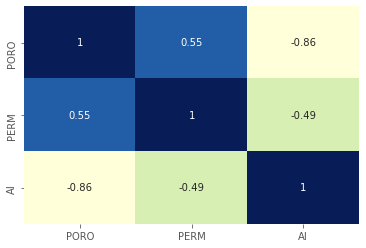

In [9]:
# covariation matrix making

cov_matrix = pd.DataFrame()

for col_i in ['PORO', 'PERM', 'AI']:
    for col_j in ['PORO', 'PERM', 'AI']:
        cov = np.cov(df_standart[col_i], df_standart[col_j])
        cov_matrix.loc[col_i, col_j] = cov[1,0]
        
sns.heatmap(cov_matrix, annot=True, cmap="YlGnBu", cbar=False)
plt.show()

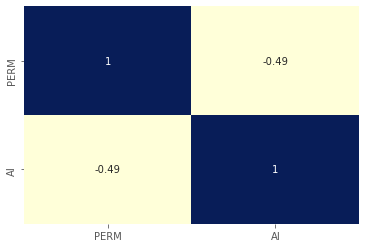

In [10]:
# redundancy matrix making

red_matrix = pd.DataFrame()

for col_i in ['PERM', 'AI']:
    for col_j in ['PERM', 'AI']:
        red_matrix.loc[col_i, col_j] = cor_matrix.loc[col_i, col_j]
        
sns.heatmap(red_matrix, annot=True, cmap="YlGnBu", cbar=False)
plt.show()

In [11]:
# closeness matrix making

closeness_matrix = pd.DataFrame()

for col in ['PERM', 'AI']:
    closeness_matrix.loc[col, 'PORO'] = cor_matrix.loc[col, 'PORO']
    
closeness_matrix

,PORO
PERM,0.542993
AI,-0.854050


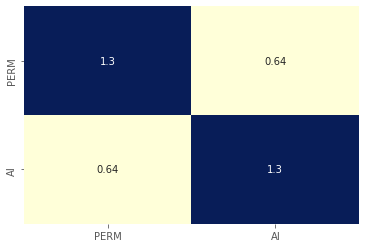

In [12]:
# inverted redundancy matrix making

inv_red_matrix = np.linalg.inv(red_matrix)
inv_red_matrix = pd.DataFrame(
    inv_red_matrix, 
    columns=['PERM', 'AI'],
    index=['PERM', 'AI']
)

sns.heatmap(inv_red_matrix, annot=True, cmap="YlGnBu", cbar=False)
plt.show()

In [13]:
# calculate the weights

W = inv_red_matrix @ closeness_matrix
W = W.rename(columns={'PORO': 'WEIGHTS'})
W

,WEIGHTS
PERM,0.167037
AI,-0.772787


In [14]:
np.sum(W)

WEIGHTS   -0.605751
dtype: float64

In [15]:
# calculate the kriging variance

kriginig_var = 1 - np.sum(closeness_matrix.PORO.values * W.WEIGHTS.values)
kriginig_var

0.24930131568971448

In [16]:
# calculate mean and std for each attribute again

df_stat = pd.DataFrame()

for col in df.columns:
    mean = np.mean(df[col])
    std = np.std(df[col])
    df_stat[col] = np.array([mean, std])

df_stat.index = ['mean', 'std']    
df_stat

,X,Y,PORO,PERM,AI
mean,629.823755,488.344828,0.150357,183.711554,4203.657220
std,340.546135,166.349756,0.049687,344.297973,1315.226292


In [17]:
# esitamated porosity

df_standart['st_PORO_est'] = np.zeros_like(df_standart.index)

for col in ['PERM', 'AI']:
    prod = W.loc[col].values * df_standart[col]
    df_standart['st_PORO_est'] += prod
    
df_standart

,PORO,PERM,AI,X,Y,st_PORO_est
0,-1.009719,-0.529622,0.689648,100,900,-0.621417
1,-0.853547,-0.497054,0.355681,100,800,-0.357892
2,-1.308188,-0.516201,1.462783,100,700,-1.216645
3,-0.843215,-0.526477,0.758790,100,600,-0.674324
4,-0.963802,-0.527913,-0.280094,100,500,0.128272
...,...,...,...,...,...,...
256,0.508886,1.293725,-0.808199,780,669,0.840666
257,-1.180024,-0.531676,1.516224,50,779,-1.260528
258,-0.227423,-0.495464,-0.169279,430,589,0.048056
259,-1.026535,-0.508367,0.570572,130,489,-0.525847


In [18]:
# back transform

df_standart['PORO_est'] = np.zeros_like(df_standart.index)
df_standart['PORO_est'] = df_standart['st_PORO_est'] * df_stat.loc['std', 'PORO'] + df_stat.loc['mean', 'PORO']
df_standart

,PORO,PERM,AI,X,Y,st_PORO_est,PORO_est
0,-1.009719,-0.529622,0.689648,100,900,-0.621417,0.119481
1,-0.853547,-0.497054,0.355681,100,800,-0.357892,0.132574
2,-1.308188,-0.516201,1.462783,100,700,-1.216645,0.089905
3,-0.843215,-0.526477,0.758790,100,600,-0.674324,0.116852
4,-0.963802,-0.527913,-0.280094,100,500,0.128272,0.156731
...,...,...,...,...,...,...,...
256,0.508886,1.293725,-0.808199,780,669,0.840666,0.192127
257,-1.180024,-0.531676,1.516224,50,779,-1.260528,0.087725
258,-0.227423,-0.495464,-0.169279,430,589,0.048056,0.152745
259,-1.026535,-0.508367,0.570572,130,489,-0.525847,0.124229


In [19]:
df_standart['PORO_stdev'] = np.zeros_like(df_standart.index)
df_standart['PORO_stdev'] = np.sqrt((df_stat.loc['std', 'PORO']**2) * kriginig_var)
df_standart

,PORO,PERM,AI,X,Y,st_PORO_est,PORO_est,PORO_stdev
0,-1.009719,-0.529622,0.689648,100,900,-0.621417,0.119481,0.024809
1,-0.853547,-0.497054,0.355681,100,800,-0.357892,0.132574,0.024809
2,-1.308188,-0.516201,1.462783,100,700,-1.216645,0.089905,0.024809
3,-0.843215,-0.526477,0.758790,100,600,-0.674324,0.116852,0.024809
4,-0.963802,-0.527913,-0.280094,100,500,0.128272,0.156731,0.024809
...,...,...,...,...,...,...,...,...
256,0.508886,1.293725,-0.808199,780,669,0.840666,0.192127,0.024809
257,-1.180024,-0.531676,1.516224,50,779,-1.260528,0.087725,0.024809
258,-0.227423,-0.495464,-0.169279,430,589,0.048056,0.152745,0.024809
259,-1.026535,-0.508367,0.570572,130,489,-0.525847,0.124229,0.024809


In [20]:
df_comp = pd.DataFrame()
df_comp['PORO'] = df['PORO']
df_comp['PORO_est'] = df_standart['PORO_est']
df_comp

,PORO,PORO_est
0,0.100187,0.119481
1,0.107947,0.132574
2,0.085357,0.089905
3,0.108460,0.116852
4,0.102468,0.156731
...,...,...
256,0.175642,0.192127
257,0.091725,0.087725
258,0.139057,0.152745
259,0.099351,0.124229


## Metrics

In [21]:
signs = 5

In [22]:
mae = np.mean(np.abs(df_comp['PORO_est'] - df_comp['PORO']))
print('MAE:', np.round(mae, signs))

MAE: 0.01952


In [23]:
mae = np.mean((df_comp['PORO_est'] - df_comp['PORO'])**2)
print('MSE:', np.round(mae, signs))

MSE: 0.00062


In [24]:
var_real, var_pred = np.var(df_comp['PORO']), np.var(df_comp['PORO_est'])
print('real var:', np.round(var_real, signs))
print('pred var:', np.round(var_pred, signs))

real var: 0.00247
pred var: 0.00185


In [25]:
mean_real, mean_pred = np.mean(df_comp['PORO']), np.mean(df_comp['PORO_est'])
print('real mean:', np.round(mean_real, signs))
print('pred mean:', np.round(mean_pred, signs))

real mean: 0.15036
pred mean: 0.15036


In [26]:
std_real, std_pred = np.std(df_comp['PORO']), np.std(df_comp['PORO_est'])
print('real std:', np.round(std_real, signs))
print('pred std:', np.round(std_pred, signs))

real std: 0.04969
pred std: 0.04305
